<a href="https://colab.research.google.com/github/griscz/beam-college/blob/main/day1/Apache_Beam_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# ***Apache Beam Demo and DataflowSQL***



## ***Apache Beam Demo***

Let's start installing and importing Beam

In [ ]:
%pip install -q apache-beam[gcp,interactive]==2.28.0 --no-warn-conflicts

In [ ]:
import logging
import re

from IPython.core.display import display, HTML

import apache_beam as beam
from apache_beam import FlatMap, Map, Create
from apache_beam import window, WindowInto
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.transforms.combiners import Count
from apache_beam.io.textio import ReadFromText
from apache_beam.io.gcp.pubsub import ReadFromPubSub
from apache_beam.io.gcp.bigquery import WriteToBigQuery

from apache_beam.runners import DataflowRunner
from apache_beam.runners.interactive.interactive_runner import InteractiveRunner
import apache_beam.runners.interactive.interactive_beam as ib

Since we are going to reach **Google Cloud Platform** to use **Dataflow**, we need to authenticate in GCP.

I have downloaded the key of a Service Account ([documentation](https://cloud.google.com/docs/authentication/production)) and stored it in my drive, in a folder called `beam-college`.



In [ ]:
import google.auth
import os

In [ ]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/drive/MyDrive/beam-college/beam-key.json'

Let's add some variables we will use later to reach **Dataflow**. You may need to create the *Google Cloud Storage Bucket* and *Pub/Sub Topic & Subscription*.

In [ ]:
project = google.auth.default()[1]
bucket = f"gs://{project}"
subscription = f"projects/{project}/subscriptions/{project}-sub"
os.environ['PROJECT'] = project

Let's get into the code now, we are going to make the *Hello World* of the data processing systems, a **wordcount**.


### Configuration

In [ ]:
options = PipelineOptions()

p = beam.Pipeline(InteractiveRunner(), options)

### Business Logic

In [ ]:
path = "gs://dataflow-samples/shakespeare/kinglear.txt"

def split_words(text):
    words = re.findall(r'[\w\']+', text.strip(), re.UNICODE)
    return [(x, 1) for x in words]

source =

count = 

### Executing the pipeline

In [ ]:
ib.show(count)

In [ ]:
url = ("https://console.cloud.google.com/dataflow/jobs/%s/%s?project=%s" %
        (pipeline._job.location, pipeline._job.id, pipeline._job.projectId))

display(HTML('Click <a href="%s" target="_new">here</a> for the details of your Dataflow job!' % url))

### Wordcount solution

<details><summary>Solution</summary>
<p>

```
p = beam.Pipeline(InteractiveRunner(), options)

path = "gs://dataflow-samples/shakespeare/kinglear.txt"

def split_words(text):
    words = re.findall(r'[\w\']+', text.strip(), re.UNICODE)
    return [(x, 1) for x in words]

source = p | ReadFromText(path)

count = (source | FlatMap(split_words)
                | Count.PerKey())

ib.show(count)
```
</p>

### Moving to DataflowRunner solution

<details><summary>Solution</summary>
<p>

```
options = PipelineOptions(
              project=project,
              region="us-central1",
              temp_location=f"{bucket}/tmp/",
              job_name="wordcount-beam-college"
)


p = beam.Pipeline(DataflowRunner(), options)

path = "gs://dataflow-samples/shakespeare/kinglear.txt"

def split_words(text):
    words = re.findall(r'[\w\']+', text.strip(), re.UNICODE)
    return [(x, 1) for x in words]

source = p | ReadFromText(path)

count = (source | FlatMap(split_words)
                | Count.PerKey())

pipeline = p.run()
```
</p>

### Moving to Streaming

<details><summary>Solution</summary>
<p>

```
options = PipelineOptions(
              project=project,
              region="us-central1",
              temp_location=f"{bucket}/tmp/",
              job_name="wordcount-beam-college-streaming",
              streaming=True
)


p = beam.Pipeline(DataflowRunner(), options)

path = "gs://dataflow-samples/shakespeare/kinglear.txt"

def split_words(text):
    words = re.findall(r'[\w\']+', text.strip(), re.UNICODE)
    return [(x, 1) for x in words]

source = (p | ReadFromPubSub(subscription=subscription)
            | "decode" >> Map(lambda b: b.decode("utf-8"))
            | WindowInto(window.FixedWindows(60)
            
count = (source | FlatMap(split_words)
                | Count.PerKey())

pipeline = p.run()
```
</p>

## ***DataflowSQL***

For this we are going to head to **BigQuery**. We are going to read from a public **PubSub topic** with taxi rides and calculate the total number of rides and total cost of those rides every minute. We are going to store this in **BigQuery**.

The elements in the **PubSub topic** look like this:

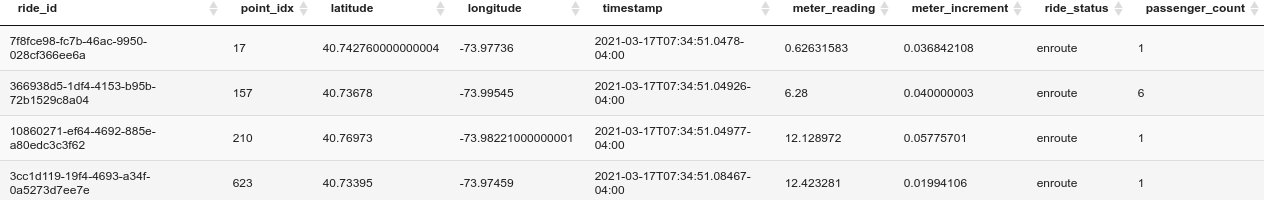

The query we are going to use:

```
SELECT
  TUMBLE_START('INTERVAL 1 MINUTE') AS period_start,
  SUM(meter_reading) AS total_cost,
  COUNT(*) AS total_rides
FROM
  pubsub.topic.`pubsub-public-data`.`taxirides-realtime`
WHERE
  ride_status = "dropoff"
GROUP BY
  TUMBLE(event_timestamp, 'INTERVAL 1 MINUTE')

```




Now we are going to do a `join` with **DataflowSQL**. We are joining the **PubSub** streaming with a table in **BigQuery**. 


To prepare the environemt, you have the instructions at the end.

```
SELECT
  ps.ride_id,
  ps.passenger_count,
  ps.meter_reading,
  ps.meter_reading * bq.discount as meter_after_discount,
  bq.discount
FROM
  pubsub.topic.`pubsub-public-data`.`taxirides-realtime` as ps
INNER JOIN
  bigquery.table.`TODO:MYPROJECT`.beam_college.discounts as bq
ON ps.passenger_count = bq.passenger
WHERE
  ps.ride_status = "dropoff"
```

### Preparing the environment

You need to create a dataset, and insert data into it.

In [ ]:
dataset_id = "beam_college"
table_id = "discounts"

In [ ]:
from google.cloud import bigquery

client = bigquery.Client()

dataset = bigquery.Dataset(f"{project}.{dataset_id}")
client.create_dataset(dataset)
print(f"Created dataset {dataset_id}")

Next cell inserts data into a new table using Beam.

In [ ]:
options = PipelineOptions(
    temp_location=f"{bucket}/tmp/"
)

discounts = [
    {"passenger": 1, "discount": 1},
    {"passenger": 2, "discount": 0.95},
    {"passenger": 3, "discount": 0.90},
    {"passenger": 4, "discount": 0.80},
    {"passenger": 5, "discount": 0.70},
    {"passenger": 6, "discount": 0.60},
    {"passenger": 7, "discount": 0.50},
]

p = beam.Pipeline(options=options)

(p | beam.Create(discounts)
   | WriteToBigQuery(
       table=table_id,
       dataset=dataset_id,
       project=project,
       schema="passenger:INTEGER,discount:FLOAT",
       create_disposition="CREATE_IF_NEEDED")
)

p.run()